In [1]:
!pip install torch torchvision matplotlib


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data


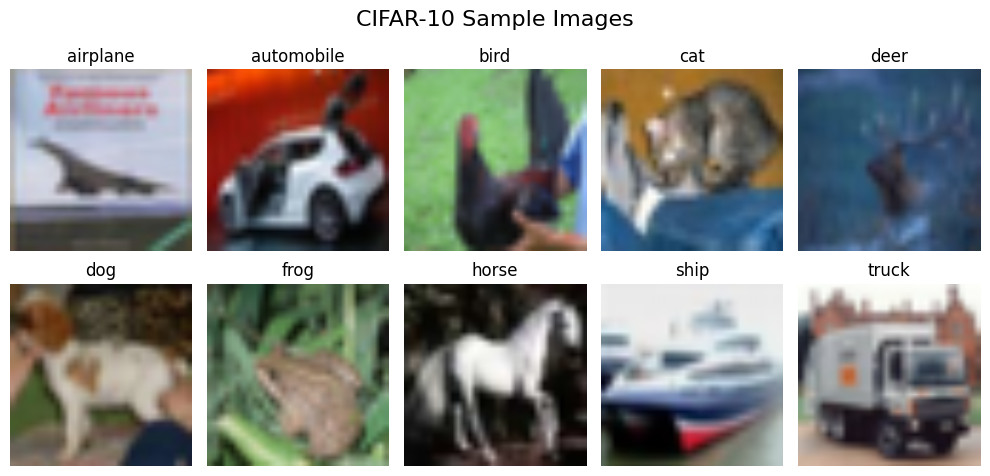

In [1]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch

# Define data preprocessing steps
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to hold one image per class
class_images = {}

# Loop through the dataset to find one image for each class
for img, label in testset:
    if classes[label] not in class_images:
        class_images[classes[label]] = img
    if len(class_images) == 10:
        break

# Create a grid of sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('CIFAR-10 Sample Images', fontsize=16)

# Display each image with its corresponding label
for i, ax in enumerate(axes.flat):
    img = class_images[classes[i]]
    
    # Upsample the image using interpolation
    img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)  # Resize to 224x224 for better display
    img = img.squeeze(0).permute(1, 2, 0)  # Reshape back to image format
    
    ax.imshow(img)
    ax.set_title(classes[i])
    ax.axis('off')

plt.tight_layout()
plt.savefig('cifar10_sample.png', dpi=200)
plt.show()


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define data preprocessing steps
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize the images
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Input channel is 3 (RGB), output channels are 32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)  # 10 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

# Instantiate the model
SimpleCNNmodel = SimpleCNN()


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(SimpleCNNmodel.parameters(), lr=0.001)



Epoch 1, Loss: 1.5765260704947859, Accuracy: 42.614%
Epoch 2, Loss: 1.214828461484836, Accuracy: 56.486%
Epoch 3, Loss: 1.0637536897988575, Accuracy: 62.458%
Epoch 4, Loss: 0.9778671813438006, Accuracy: 65.51%
Epoch 5, Loss: 0.9146866810596203, Accuracy: 67.61%
Epoch 6, Loss: 0.8660866566326307, Accuracy: 69.508%
Epoch 7, Loss: 0.8290851733568684, Accuracy: 70.794%
Epoch 8, Loss: 0.7912793418635493, Accuracy: 72.084%
Epoch 9, Loss: 0.7611670638136852, Accuracy: 73.254%
Epoch 10, Loss: 0.7334692687024851, Accuracy: 74.094%
Finished Training


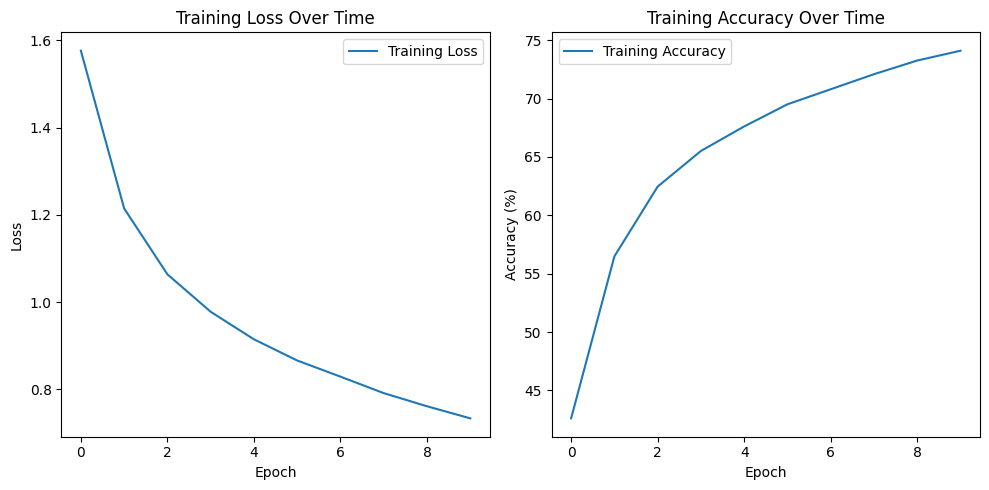

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device (GPU）
SimpleCNNmodel.to(device)

# Lists to store training loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = SimpleCNNmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store values for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {accuracy}%')

print('Finished Training')

# Plot the training loss
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Set the model to evaluation mode
SimpleCNNmodel.eval()

correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = SimpleCNNmodel(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 71.76%


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-34 model
resnet34 = models.resnet34(pretrained=True)


resnet34.fc = nn.Linear(resnet34.fc.in_features, 10)


resnet34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  
    resnet34.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = resnet34(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 1.0209, Accuracy: 64.52%
Epoch 2, Loss: 0.7183, Accuracy: 75.48%
Epoch 3, Loss: 0.6206, Accuracy: 78.64%
Epoch 4, Loss: 0.5816, Accuracy: 80.15%
Epoch 5, Loss: 0.5309, Accuracy: 81.59%
Epoch 6, Loss: 0.4928, Accuracy: 83.02%
Epoch 7, Loss: 0.4899, Accuracy: 83.04%
Epoch 8, Loss: 0.4452, Accuracy: 84.64%
Epoch 9, Loss: 0.4187, Accuracy: 85.50%
Epoch 10, Loss: 0.4984, Accuracy: 83.08%
Finished Training


In [ ]:
# Evaluation loop
resnet34.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet34(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 80.36%


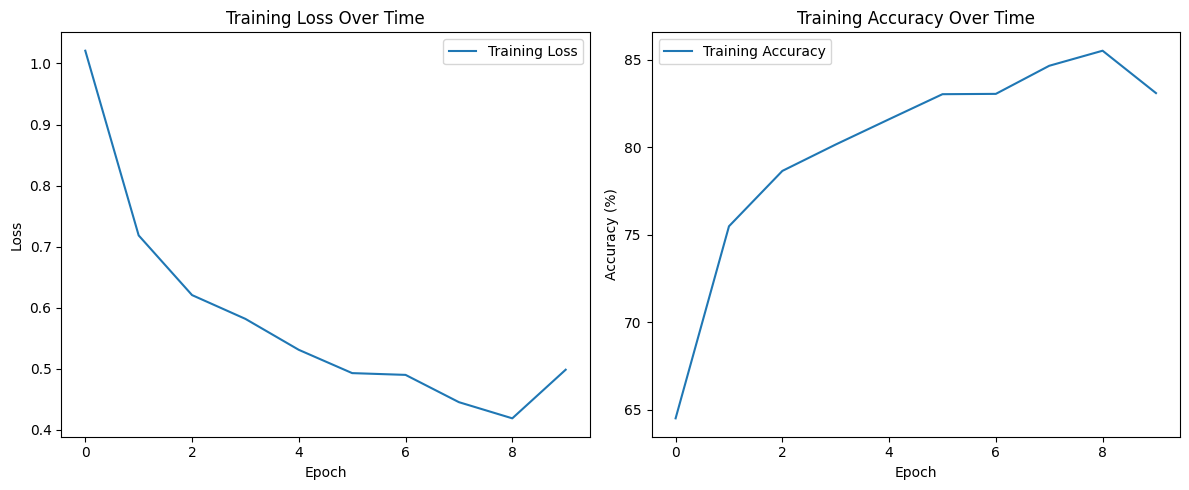

In [ ]:
# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Load the pretrained VGG-19 model
vgg19 = models.vgg19(pretrained=True)

# Modify the fully connected layer for 10 classes
vgg19.classifier[6] = nn.Linear(4096, 10)

# Move the model to the device 
vgg19.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 62.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  
    vgg19.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = vgg19(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 2.3357, Accuracy: 9.83%
Epoch 2, Loss: 2.3045, Accuracy: 9.94%
Epoch 3, Loss: 2.3043, Accuracy: 9.99%
Epoch 4, Loss: 2.3039, Accuracy: 9.80%
Epoch 5, Loss: 2.3038, Accuracy: 9.86%
Epoch 6, Loss: 2.3037, Accuracy: 9.78%
Epoch 7, Loss: 2.3033, Accuracy: 9.76%
Epoch 8, Loss: 2.3032, Accuracy: 10.10%
Epoch 9, Loss: 2.3033, Accuracy: 9.93%
Epoch 10, Loss: 2.3033, Accuracy: 9.87%
Finished Training


In [ ]:
# Evaluation loop
vgg19.eval()  
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19(inputs)  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 10.00%


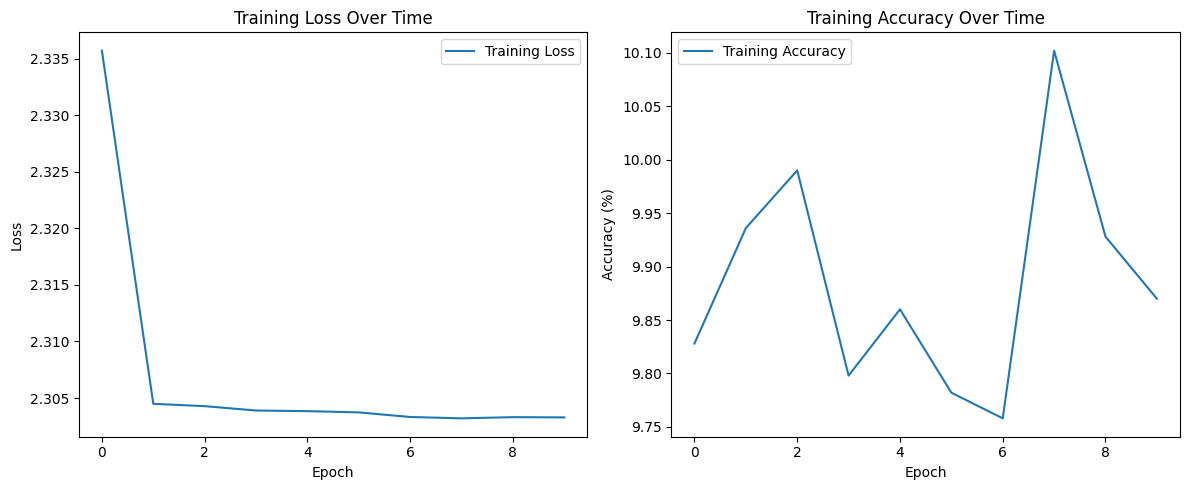

In [ ]:
# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Load the pretrained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Modify the fully connected layer for 10 classes
vgg16.classifier[6] = nn.Linear(4096, 10)

# Move the model to the device 
vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs 
    vgg16.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = vgg16(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass 
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 2.3132, Accuracy: 9.95%
Epoch 2, Loss: 2.3047, Accuracy: 9.71%
Epoch 3, Loss: 2.3039, Accuracy: 10.16%
Epoch 4, Loss: 2.3041, Accuracy: 9.81%
Epoch 5, Loss: 2.3034, Accuracy: 9.76%
Epoch 6, Loss: 2.3030, Accuracy: 10.17%
Epoch 7, Loss: 2.3036, Accuracy: 10.20%
Epoch 8, Loss: 2.3038, Accuracy: 9.87%
Epoch 9, Loss: 2.3035, Accuracy: 9.95%
Epoch 10, Loss: 2.3035, Accuracy: 9.89%
Finished Training


In [ ]:
# Evaluation loop
vgg16.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 10.00%


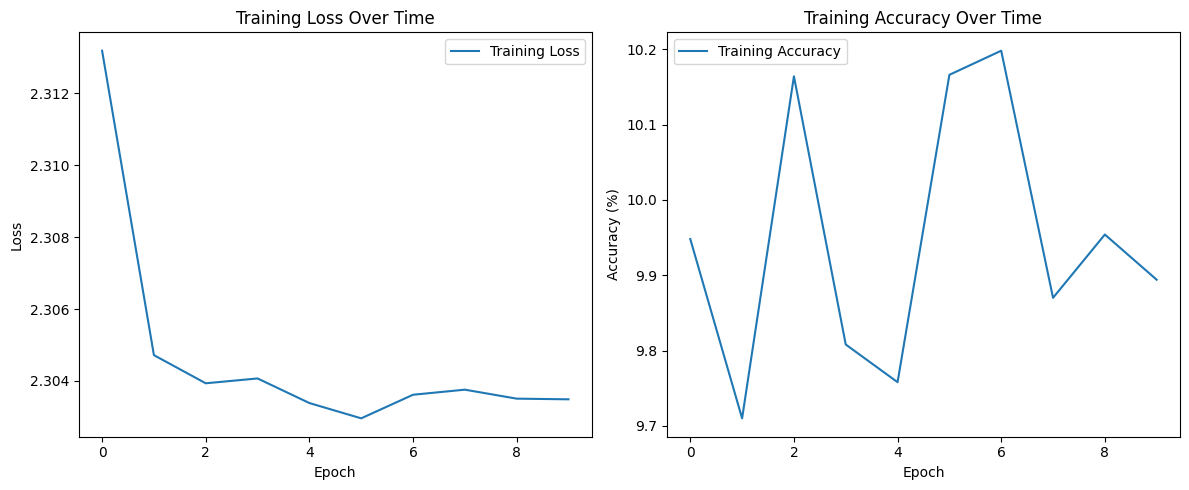

In [ ]:
# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the fully connected layer for 10 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Move the model to the device 
resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs 
    resnet18.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = resnet18(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass 
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 1.0459, Accuracy: 63.78%
Epoch 2, Loss: 0.7478, Accuracy: 74.42%
Epoch 3, Loss: 0.6479, Accuracy: 78.05%
Epoch 4, Loss: 0.5934, Accuracy: 79.67%
Epoch 5, Loss: 0.5577, Accuracy: 81.02%
Epoch 6, Loss: 0.5189, Accuracy: 82.21%
Epoch 7, Loss: 0.5024, Accuracy: 82.73%
Epoch 8, Loss: 0.4762, Accuracy: 83.64%
Epoch 9, Loss: 0.4578, Accuracy: 84.35%
Epoch 10, Loss: 0.4340, Accuracy: 85.22%
Finished Training


In [ ]:
# Evaluation loop
resnet18.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 82.24%


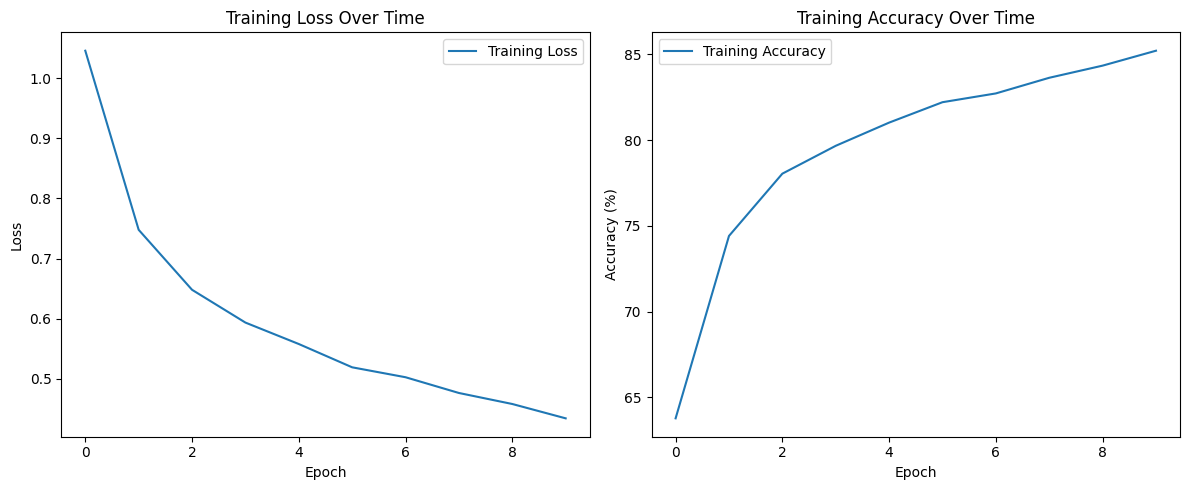

In [ ]:
# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Load the pretrained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the fully connected layer for 10 classes 
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Move the model to the device 
resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs 
    resnet50.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = resnet50(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass 
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 1.0508, Accuracy: 64.16%
Epoch 2, Loss: 0.9673, Accuracy: 67.51%
Epoch 3, Loss: 1.1572, Accuracy: 60.43%
Epoch 4, Loss: 0.7798, Accuracy: 73.16%
Epoch 5, Loss: 0.6528, Accuracy: 77.39%
Epoch 6, Loss: 0.5846, Accuracy: 79.95%
Epoch 7, Loss: 0.5504, Accuracy: 81.20%
Epoch 8, Loss: 0.5568, Accuracy: 81.04%
Epoch 9, Loss: 0.6045, Accuracy: 79.65%
Epoch 10, Loss: 0.5941, Accuracy: 79.70%
Finished Training


In [ ]:
# Evaluation loop
resnet50.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 80.94%


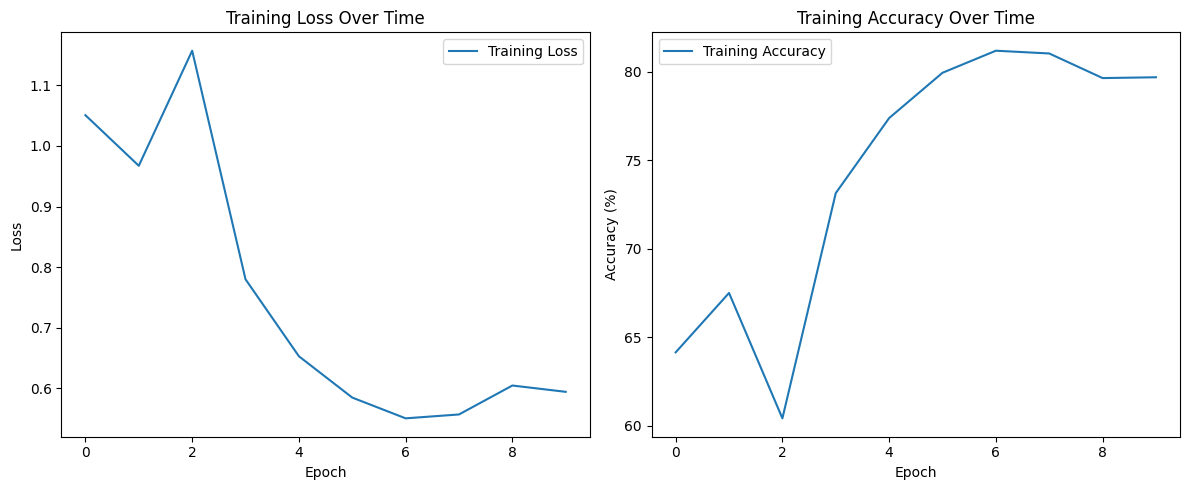

In [ ]:
# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [2]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import timm  # Library for pretrained models

# Check if GPU is available, if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the EfficientNet-B0 model with pretrained weights
efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the classifier to suit CIFAR-10 
efficientnet.classifier = nn.Linear(efficientnet.classifier.in_features, 10)

# Move the model to the device 
efficientnet.to(device)



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)


In [ ]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs 
    efficientnet.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = efficientnet(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 1, Loss: 1.0778, Accuracy: 62.41%
Epoch 2, Loss: 0.6814, Accuracy: 76.64%
Epoch 3, Loss: 0.5790, Accuracy: 80.22%
Epoch 4, Loss: 0.5140, Accuracy: 82.33%
Epoch 5, Loss: 0.4768, Accuracy: 83.80%
Epoch 6, Loss: 0.4309, Accuracy: 85.27%
Epoch 7, Loss: 0.4047, Accuracy: 86.05%
Epoch 8, Loss: 0.3786, Accuracy: 87.04%
Epoch 9, Loss: 0.3545, Accuracy: 87.84%
Epoch 10, Loss: 0.3327, Accuracy: 88.47%
Finished Training


In [ ]:
# Evaluation loop
efficientnet.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = efficientnet(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')


Accuracy on the CIFAR-10 test set: 84.68%


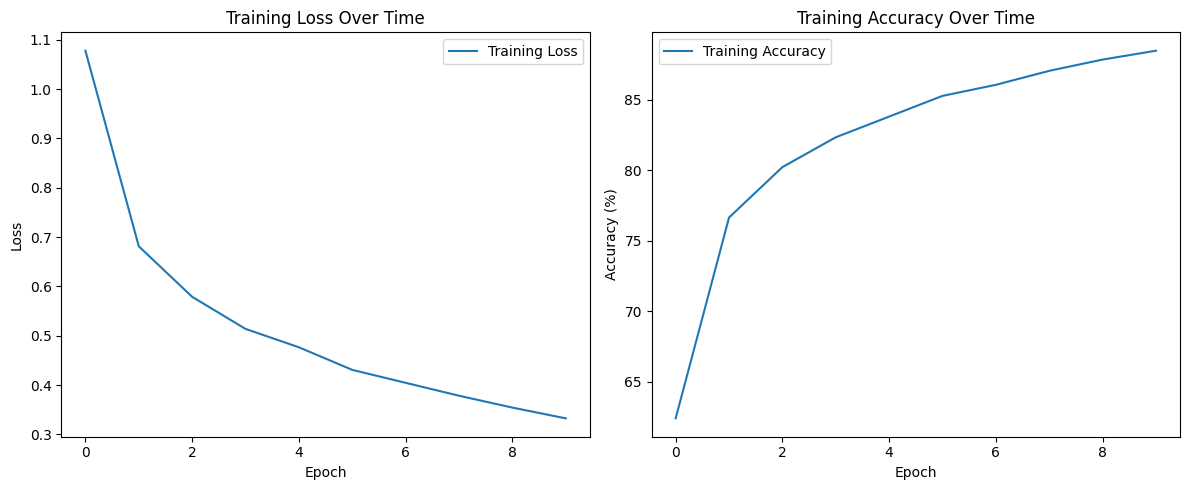

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define data preprocessing steps
transform = transforms.Compose([
    transforms.Resize(224),  # Resize the images to 224x224 (required input size for EfficientNet)
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(224, padding=4),  # Randomly crop the images 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize the images
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:04<00:00, 38937974.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn
import timm  # Library for pretrained models

# Check if GPU is available, if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the EfficientNet-B0 model with pretrained weights
efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the classifier to suit CIFAR-10 
efficientnet.classifier = nn.Linear(efficientnet.classifier.in_features, 10)

# Move the model to the device 
efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)

In [6]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(10):  # Train for 10 epochs 
    efficientnet.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = efficientnet(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass 
        optimizer.step()  # Update the weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total

    # Store loss and accuracy for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')

Epoch 1, Loss: 0.2953, Accuracy: 90.31%
Epoch 2, Loss: 0.1453, Accuracy: 95.23%
Epoch 3, Loss: 0.0997, Accuracy: 96.63%
Epoch 4, Loss: 0.0877, Accuracy: 97.02%
Epoch 5, Loss: 0.0717, Accuracy: 97.51%
Epoch 6, Loss: 0.0630, Accuracy: 97.86%
Epoch 7, Loss: 0.0535, Accuracy: 98.15%
Epoch 8, Loss: 0.0507, Accuracy: 98.34%
Epoch 9, Loss: 0.0508, Accuracy: 98.29%
Epoch 10, Loss: 0.0447, Accuracy: 98.37%
Finished Training


In [7]:
# Evaluation loop
efficientnet.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = efficientnet(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy on the test set
accuracy = 100 * correct / total
print(f'Accuracy on the CIFAR-10 test set: {accuracy:.2f}%')

Accuracy on the CIFAR-10 test set: 94.66%


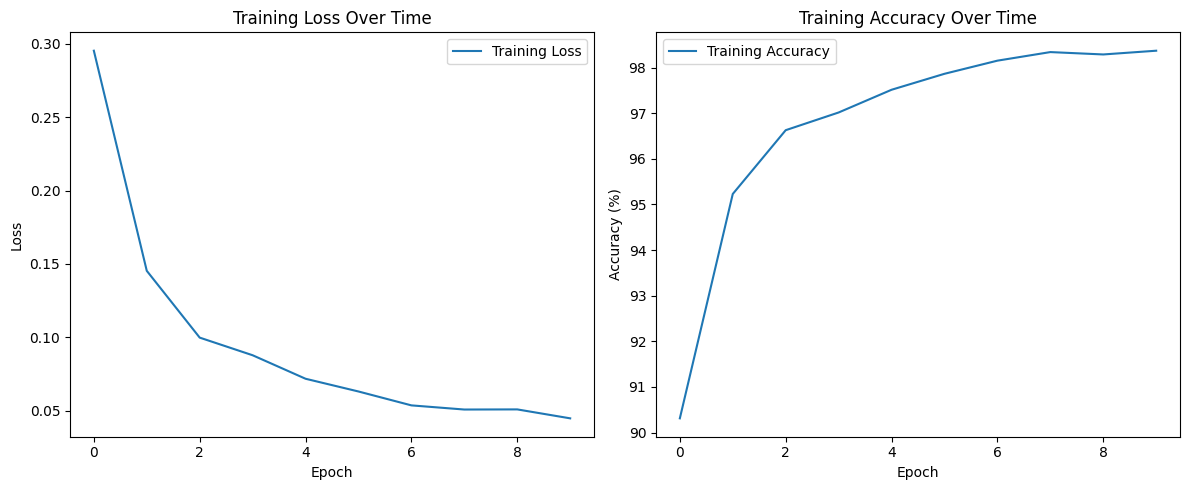

In [8]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy curves
plt.figure(figsize=(12,5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
